This notebook is my project for module 3 of FAIKR that I did during my master in AI.

The code contains few comments that decribe very shortly what I did, for more information there is a report attached that explains my idea and all the steps and results.

In [2]:

import pandas as pd
from pgmpy.inference import VariableElimination
import pylab as plt
import networkx as nx
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import time
import numpy as np
from itertools import combinations

#Class to perform inference
class MyInference():
    #constructor
    def __init__(self, model):
        self.model=model
        self.approximate_inference = BayesianModelSampling(model)
        self.exact_inference = VariableElimination(model)
    
    #used by get_evidences to remove invalid combination in the output like ["asthma":no,"asthma":yes]
    def __remove_invalid(self,my_list):
        l=[]
        num_deleted=0
        for a in my_list:
            l.append(a)
        for index, elem in enumerate(my_list):
            if len(elem)>1:
                break_out_flag=False
                for index2, state in enumerate(elem):
                    for state2 in elem[index2+1:]:
                        if state[0] in state2:
                            l.pop(index-num_deleted)
                            num_deleted=num_deleted+1
                            break_out_flag=True
                            break
                    if break_out_flag:
                        break
        return l

    #takes as input a list of queries and a pandas dataframe. Returns all the combination of the queries (usefull to have a lot of evidences to do queries).
    #Example: 
    #input queries->["smoke","asthma"]  
    #output->[["smoke":yes],["smoke":no],["asthma":yes],["asthma":no], ["asthma":no,"smoke":no],["asthma":no,"smoke":yes],["asthma":yes,"smoke":no],["asthma":yes,"smoke":yes]]
    def get_evidences(self,queries,data):
        list_of_evidences=[]
        list_of_val=[]
        for query in queries:
            list_of_val.append(np.unique(data[query]))
            for val in list_of_val[0]:
                #controllare se val è un numero o no??
                list_of_evidences.append(State(query,val))
            list_of_val=[]
        #generates all the subsets exluding the empty one
        s = sum([list(map(list, combinations(list_of_evidences, i))) for i in range(len(list_of_evidences) + 1)], [])[1:]
        s=self.__remove_invalid(s)
        return s

    #computes the relative error between the exact and the approximate inference
    def __relative_error(self, sample_probs, exact_probs,is_likelihood):
        if is_likelihood:
            array, sample_probs = sample_probs
            sample_probs = list(sample_probs.values())
        return np.average(np.absolute((exact_probs.values-sample_probs)))/np.average(exact_probs.values)

    #perform the exact inference end returns also the execution time
    def my_exact_inference(self,query,evidence=None):
        time_exacxt_inference = time.time()
        done_query = self.exact_inference.query(query,evidence,show_progress=False)
        execution_time = time.time() - time_exacxt_inference
        return done_query, execution_time

    #perform the approximate inference (rejection sampling) end returns also the execution time and the generation time
    def my_rejection_sample(self,query,evidence=None,size=100):
        time_approx_inference = time.time()
        approximate = self.approximate_inference.rejection_sample(evidence=evidence,size=size,show_progress=False)
        generation_time = time.time() - time_approx_inference
        time_approx_inference = time.time()
        unique, counts = np.unique(approximate[query], return_counts=True)
        counts = (counts/len(approximate))
        execution_time = time.time() - time_approx_inference
        return counts, execution_time, generation_time

  #perform the approximate inference (likelihood weighting) end returns also the execution time and the generation time
    def my_likelihood_weighting(self,query,evidence=None,size=100):
        time_approx_inference = time.time()
        approximate = self.approximate_inference.likelihood_weighted_sample(evidence=evidence, size=size,show_progress=False)
        generation_time = time.time() - time_approx_inference
        time_approx_inference = time.time()
        sample = self.__return_weighted_probs(approximate[query],approximate['_weight'])
        execution_time = time.time() - time_approx_inference
        return sample, execution_time, generation_time

    #returns the probabilities for the likelihood weighting
    def __return_weighted_probs(self, samples, weights):
        unique = np.unique(samples)
        counts = {}
        for elem in unique:
            counts[elem] = 0
        iterator = np.nditer(samples, flags=['refs_ok','f_index'])
        for value in iterator:
            counts[str(value)] += weights[iterator.index]
        for elem in unique:
            if np.sum(weights)!=0:
                counts[elem] /=np.sum(weights)
            else: counts[elem]=0
        return unique, counts

    #return False if the query is also in the evidences
    # Example:
    # input: query->"age" evidences->["smoke":yes, "age":adult]
    # output: False 
    def __not_in(self, query,evidences):
        for evidence in evidences:
            if query in evidence:
                return False
        return True

    #takes a list of queries and a list (of lists) of evidences and the size fer the approximate inference
    #returns some lists that contain some data obtained by do the inference
    def comparison(self, list_of_queries, list_of_evidences, size):
        time_exact_inference_list = []
        time_approx_inference_likelihood = []
        time_approx_generation_likelihood = []
        error_likelihood = []
        time_approx_inference_rejection = []
        time_approx_generation_rejection = []
        error_rejection = []
        for query in list_of_queries:
            for evidences in list_of_evidences:
                if self.__not_in(query,evidences):
                    #exact inference
                    done_query, execution_time_exact = self.my_exact_inference([query],dict(evidences))
                    time_exact_inference_list.append(execution_time_exact)
                    #approx inference with likelihood weight
                    sample, execution_time_approx, generation_time = self.my_likelihood_weighting(query,evidences,size)
                    error_likelihood.append(self.__relative_error(sample,done_query,True)*100)
                    time_approx_inference_likelihood.append(execution_time_approx)
                    time_approx_generation_likelihood.append(generation_time)
                    #approx inference with rejection
                    sample, execution_time_approx, generation_time = self.my_rejection_sample(query,evidences,size)
                    error_rejection.append(self.__relative_error(sample,done_query,False)*100)
                    time_approx_inference_rejection.append(execution_time_approx)
                    time_approx_generation_rejection.append(generation_time)
            print(query+" done")

        return [time_exact_inference_list,
                time_approx_inference_likelihood,time_approx_inference_rejection,
                time_approx_generation_likelihood,time_approx_generation_rejection,
                error_rejection, error_likelihood]

    

First of all I taked the data from an xlsx file.
Each attribute has a domain of at most 3 values so preprocessing is not needed.

In [3]:
asthma_data = pd.read_excel('asma.xlsx',names=['sex','age','urbanization','education','geo_area','allergy','smoke','sedentary','asthma'])
asthma_data


,sex,age,urbanization,education,geo_area,allergy,smoke,sedentary,asthma
0,male,adult,low,low,south/islands,yes,yes,yes,yes
1,female,old,low,low,south/islands,yes,no,yes,yes
2,female,adult,high,high,centre,no,no,yes,yes
3,male,adult,medium,low,south/islands,yes,no,no,no
4,female,adult,low,high,north,no,no,no,no
...,...,...,...,...,...,...,...,...,...
2750,male,adult,low,low,south/islands,no,yes,yes,no
2751,male,old,high,low,north,no,no,yes,yes
2752,female,old,medium,high,south/islands,no,no,yes,no
2753,male,young,medium,low,south/islands,no,no,yes,no


I built the network as described in the attached report (I used some colors only to visual purposes).

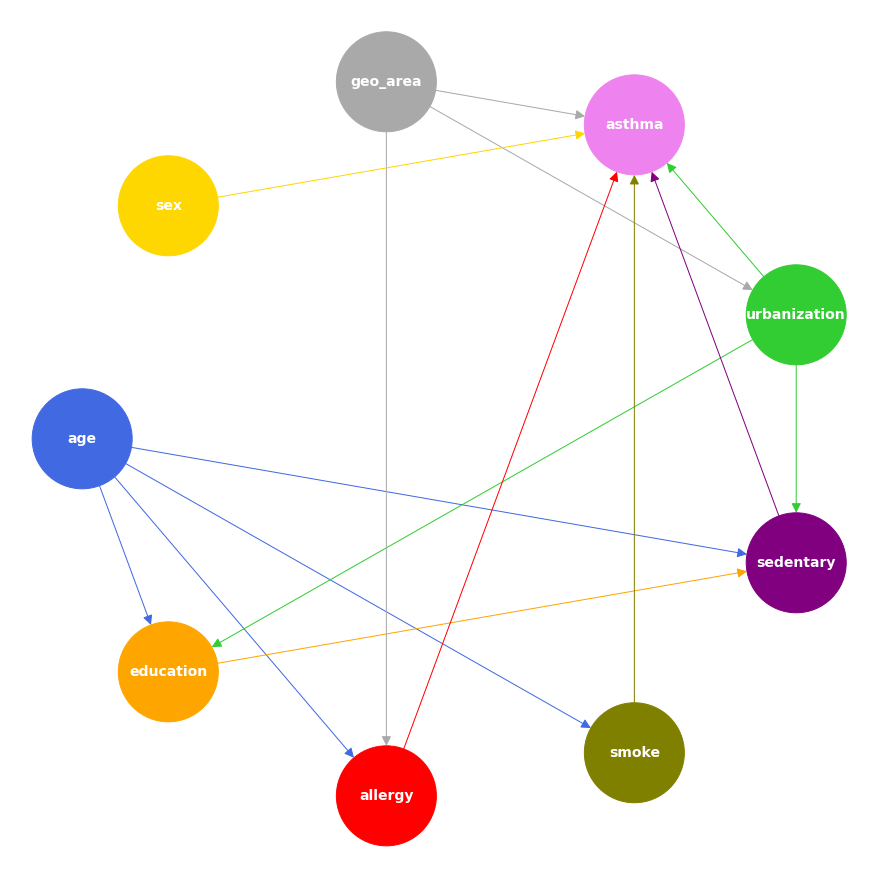

In [5]:
asthma_network = BayesianNetwork()
edges = [ ('age', 'education'), ('age', 'allergy'), 
                                    ('age', 'smoke'), ('age', 'sedentary'), ('urbanization', 'education'),
                                    ('urbanization', 'sedentary'),('urbanization', 'asthma'),
                                    ('education','sedentary'),('geo_area','urbanization'),('geo_area','asthma'),
                                    ('geo_area','allergy'),('allergy','asthma'),('smoke','asthma'),
                                    ('sedentary','asthma'),('sex','asthma')]
asthma_network.add_edges_from(edges)
G = nx.Graph()
G.add_edge('age','education',color='royalblue')
G.add_edge('age','allergy',color='royalblue')
G.add_edge('age','smoke',color='royalblue')
G.add_edge('age','sedentary',color='royalblue')
G.add_edge('urbanization','education',color='limegreen')
G.add_edge('urbanization','sedentary',color='limegreen')
G.add_edge('urbanization','asthma',color='limegreen')
G.add_edge('education','sedentary',color='orange')
G.add_edge('geo_area','urbanization',color='darkgrey')
G.add_edge('geo_area','allergy',color='darkgrey')
G.add_edge('geo_area','asthma',color='darkgrey')
G.add_edge('allergy','asthma',color='r')
G.add_edge('smoke','asthma',color='olive')
G.add_edge('sedentary','asthma',color='purple')
G.add_edge('sex','asthma',color='gold')
colors = [G[u][v]['color'] for u,v in edges]
nx.draw(asthma_network, edgelist = edges,font_weight='bold',edge_color=colors,font_color='w',font_size=14,nodelist=['age','urbanization','education','geo_area','allergy','smoke','sedentary','asthma','sex'],
node_color=['royalblue','limegreen','orange','darkgrey','r','olive','purple','violet','gold'],with_labels=True,pos=nx.shell_layout(asthma_network), node_size=10000,arrows=True,arrowstyle='-|>',arrowsize=20)

plt.rcParams["figure.figsize"] = (12,12)
plt.show()


I fitted the network using the MLE and than I printed the learned CPTs.

In [4]:
asthma_network.fit(asthma_data, estimator=MaximumLikelihoodEstimator)
for cpd in asthma_network.get_cpds():
    print('CPT of: ' + cpd.variable)
    print(cpd)
    print("\n")

CPT of: age
+------------+----------+
| age(adult) | 0.508893 |
+------------+----------+
| age(old)   | 0.377132 |
+------------+----------+
| age(young) | 0.113975 |
+------------+----------+


CPT of: education
+-----------------+-----+----------------------+
| age             | ... | age(young)           |
+-----------------+-----+----------------------+
| urbanization    | ... | urbanization(medium) |
+-----------------+-----+----------------------+
| education(high) | ... | 0.4701492537313433   |
+-----------------+-----+----------------------+
| education(low)  | ... | 0.5298507462686567   |
+-----------------+-----+----------------------+


CPT of: allergy
+--------------+--------------------+-----+-------------------------+
| age          | age(adult)         | ... | age(young)              |
+--------------+--------------------+-----+-------------------------+
| geo_area     | geo_area(centre)   | ... | geo_area(south/islands) |
+--------------+--------------------+-----+----

Checking if the sum of the probabilities for each state is equal to 1 (tol=0.01).

In [5]:
asthma_network.check_model()

True

In [6]:
inference = MyInference(asthma_network)

In [7]:
print(inference.my_exact_inference(["asthma"])[0])

+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.5747 |
+-------------+---------------+
| asthma(yes) |        0.4253 |
+-------------+---------------+


I performed some queries to see if the results make sense.


In the following cell I performed P(asthma | smoke, sedentary)

In [8]:
for smoke in (list(asthma_data["smoke"].value_counts().index)):
    for sedentary in (list(asthma_data["sedentary"].value_counts().index)):
        print("smoke: "+smoke+" sedentary: "+sedentary)
        print(inference.my_exact_inference(["asthma"],
            {
                'smoke':smoke,
                'sedentary':sedentary
            })[0])
        print()

smoke: no sedentary: yes
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.5654 |
+-------------+---------------+
| asthma(yes) |        0.4346 |
+-------------+---------------+

smoke: no sedentary: no
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.6122 |
+-------------+---------------+
| asthma(yes) |        0.3878 |
+-------------+---------------+

smoke: yes sedentary: yes
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.5413 |
+-------------+---------------+
| asthma(yes) |        0.4587 |
+-------------+---------------+

smoke: yes sedentary: no
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.6418 |
+-------------+---------------+
| asthma(yes) |        0.3582 |
+-------------+---------------+



In the following cell I performed P(asthma | age, allergy)

In [9]:
for age in (list(asthma_data["age"].value_counts().index)):
    for allergy in (list(asthma_data["allergy"].value_counts().index)):
        print("age: "+age+" allergy: "+allergy)
        print(inference.my_exact_inference(["asthma"],{'age':age,'allergy':allergy})[0])
        print()


age: adult allergy: no
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.7003 |
+-------------+---------------+
| asthma(yes) |        0.2997 |
+-------------+---------------+

age: adult allergy: yes
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.2552 |
+-------------+---------------+
| asthma(yes) |        0.7448 |
+-------------+---------------+

age: old allergy: no
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.6866 |
+-------------+---------------+
| asthma(yes) |        0.3134 |
+-------------+---------------+

age: old allergy: yes
+-------------+---------------+
| asthma      |   phi(asthma) |
+=============+===============+
| asthma(no)  |        0.2478 |
+-------------+---------------+
| asthma(yes) |        0.7522 |
+-------------+---------------+

age: young

At this point, I genereted some evidences using the get_evidences methods.

As written in the under cell, using the original list to generats the evidences causes a 6 hours run time for the next cell, I did this thing only to have a lot of data that are useful to make my analysis. 

In [10]:

list_of_queries=['age','urbanization','smoke','sedentary','asthma']
#Uncomment the following line to run the next block in arround 1 minute. Otherwise it will take arround 6 hours
#list_of_queries=['smoke','sedentary']
list_of_evidences=inference.get_evidences(list_of_queries,asthma_data)
list_of_queries=['sex','education','geo_area','allergy','age','urbanization','smoke','sedentary','asthma']
print(len(list_of_evidences))                 


431


In the following cell I performed all the queries using the comparison method of the MyInference class

In [11]:

size10_2 = inference.comparison(list_of_queries,list_of_evidences,10**2)
print("done")
size10_3 = inference.comparison(list_of_queries,list_of_evidences,10**3)
print("done")
size10_4 = inference.comparison(list_of_queries,list_of_evidences,10**4)
print("done")
plt_list = [size10_2,size10_3,size10_4]


sex done
education done
geo_area done
allergy done
age done
urbanization done
smoke done
sedentary done
asthma done
done
sex done
education done
geo_area done
allergy done
age done
urbanization done
smoke done
sedentary done
asthma done
done
sex done
education done
geo_area done
allergy done
age done
urbanization done
smoke done
sedentary done
asthma done
done


Finally, I used some plots to make the comparison

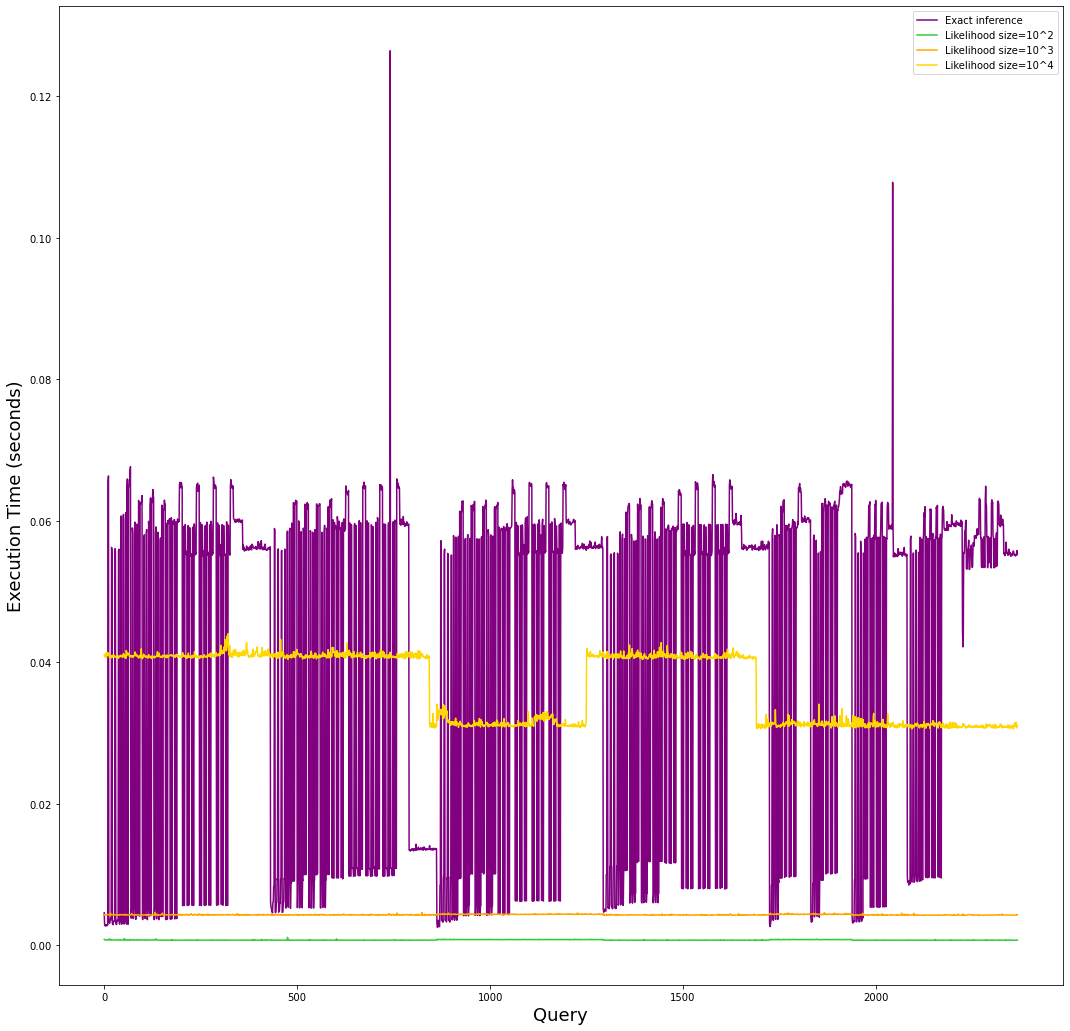

ex lik:  0.000735462291058378 0.00430537750814653 0.03650085151472523
exact:  0.04074403390533873


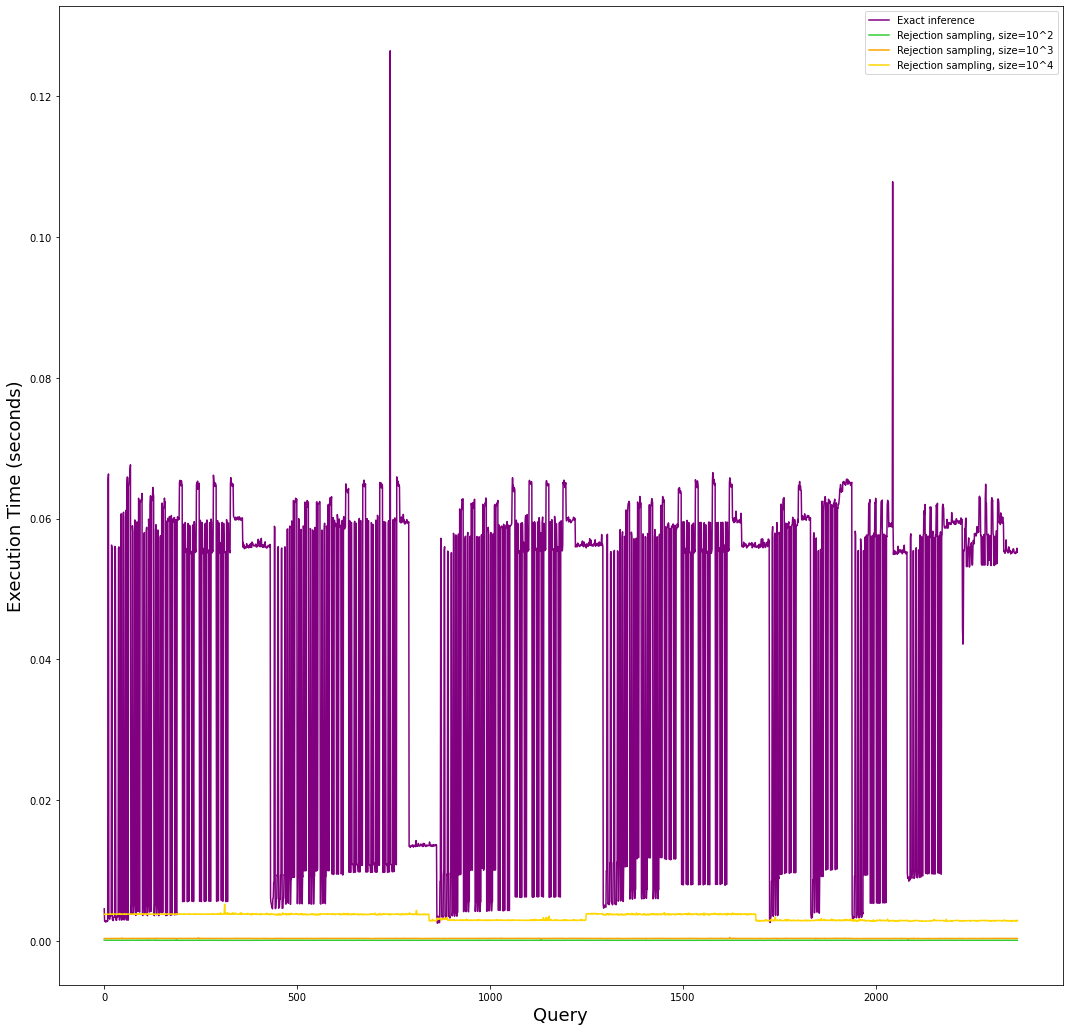

ex rj:  0.0001094829799457094 0.00036783937567842626 0.003409635078871759


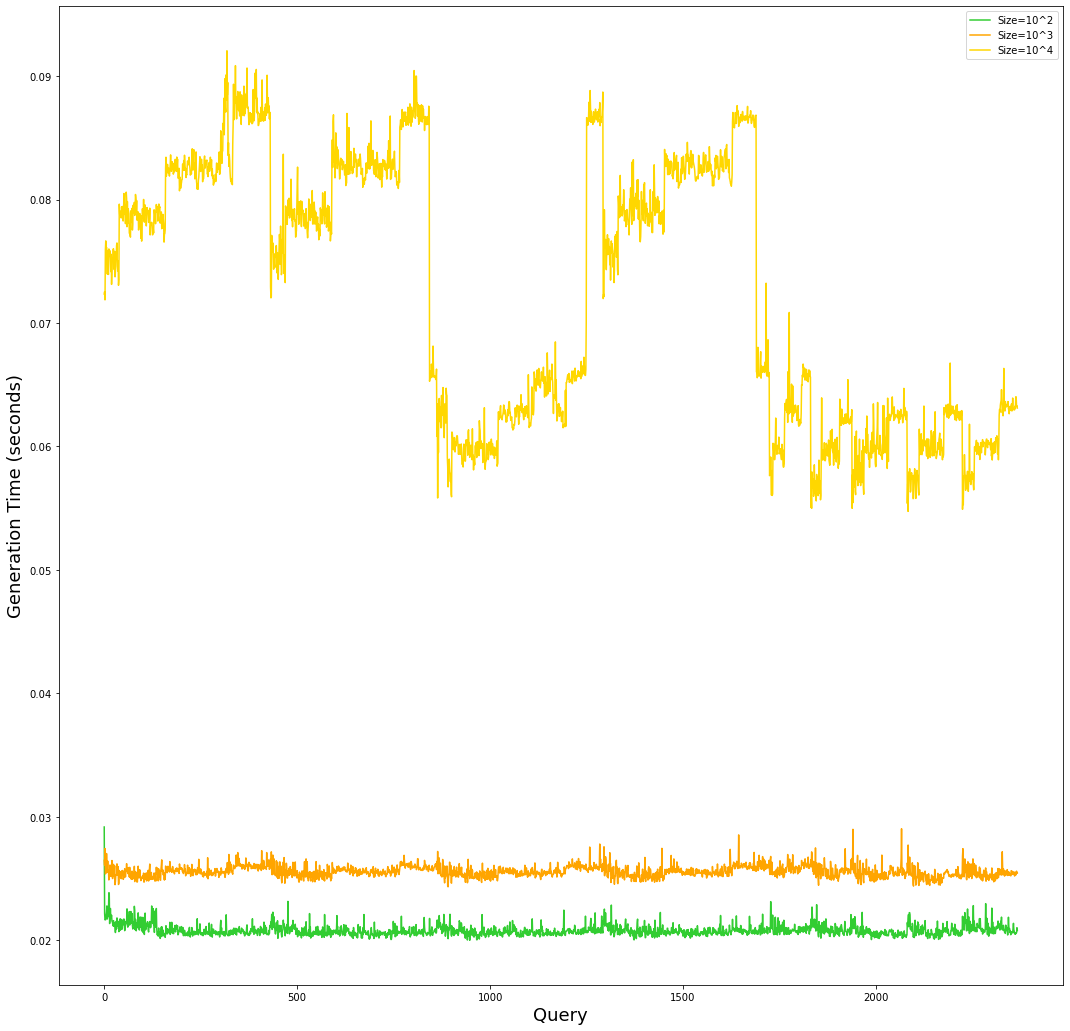

gen likelihood:  0.020793814471768184 0.02556285578135856 0.0725752846017184
gen rs:  0.1592037214425026 0.8294914814304791 10.032359732824084


/var/folders/_y/609_tkp904v81t5ks9sx8wmc0000gn/T/ipykernel_1423/2735015763.py:73: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(labels = labels, Fontsize=18)


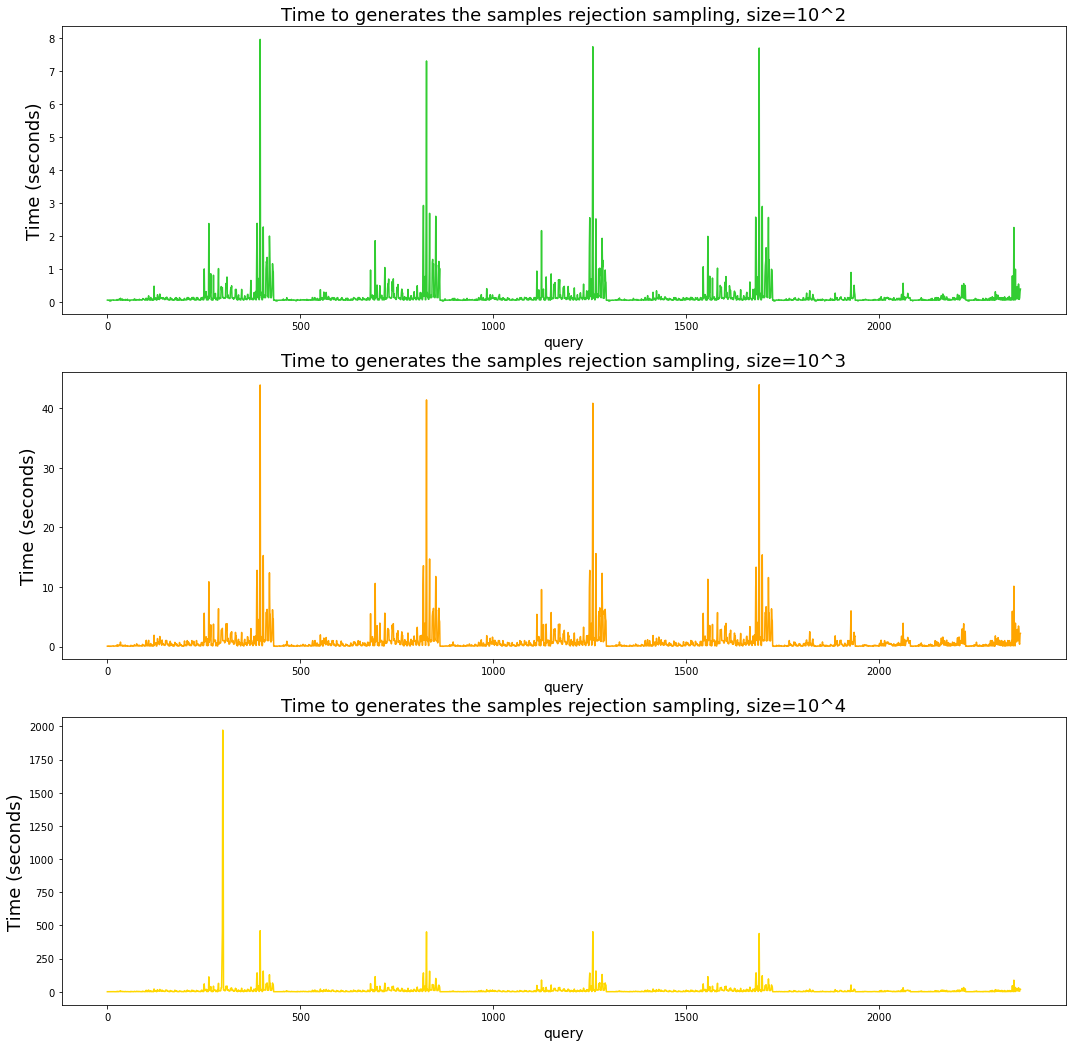

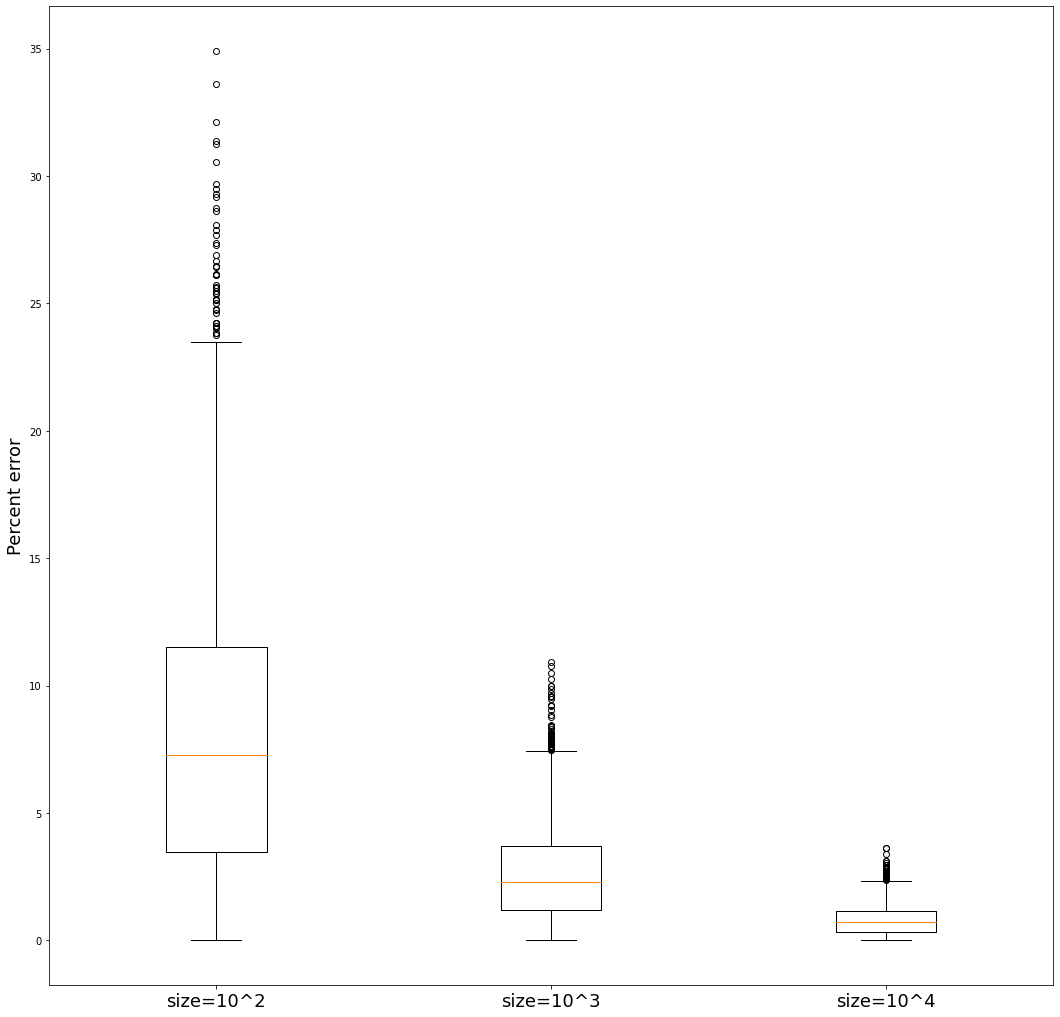

Mean of errors:  8.259819610651322 2.6230123605529734 0.8146061825619031


/var/folders/_y/609_tkp904v81t5ks9sx8wmc0000gn/T/ipykernel_1423/2735015763.py:89: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(labels = labels, Fontsize=18)


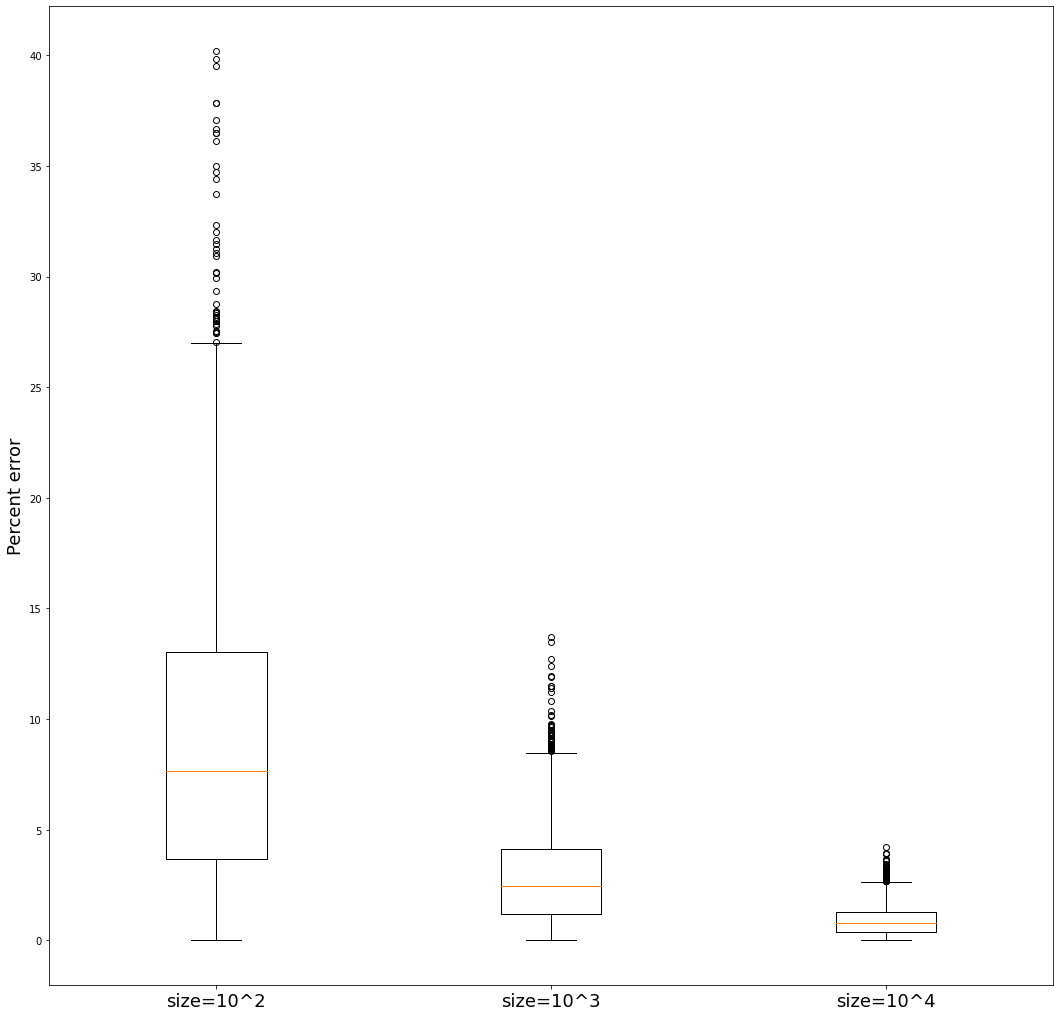

Mean of errors:  9.085742010571922 2.9030364708244107 0.9073702283727082


In [13]:

plt.rcParams["figure.figsize"] = (18,18)
color_list = ['limegreen','orange','gold']

x_vals = range(len(plt_list[0][0]))
plt.plot(range(len(plt_list[0][0])), plt_list[0][0],color='purple', label="Exact inference")
for j in range(3):
    plt.plot(x_vals,plt_list[j][1],color=color_list[j],label="Likelihood size=10^"+str(j+2))
plt.xlabel("Query", fontsize=18)
plt.ylabel("Execution Time (seconds)", fontsize=18)  
plt.legend()
#plt.title("Comparison of execution time between exact inference and approximate inference\nwith likelihood weight")
plt.savefig('img/ex_time_likelihood.jpg', bbox_inches='tight')
plt.show()
print("ex lik: ",np.mean(plt_list[0][1]),np.mean(plt_list[1][1]),np.mean(plt_list[2][1]))
print("exact: ",np.mean(plt_list[0][0]))

x_vals = range(len(plt_list[0][0]))
x_vals = range(len(plt_list[0][0]))
plt.plot(range(len(plt_list[0][0])), plt_list[0][0],color='purple', label="Exact inference")
for j in range(3):
    plt.plot(x_vals,plt_list[j][2],color=color_list[j],label="Rejection sampling, size=10^"+str(j+2))
plt.xlabel("Query", fontsize=18)
plt.ylabel("Execution Time (seconds)", fontsize=18)  
plt.legend()
#plt.title("Comparison of execution time between exact inference and approximate inference\nwith rejection sampling")
plt.savefig('img/ex_time_rs.jpg', bbox_inches='tight')
plt.show()
print("ex rj: ",np.mean(plt_list[0][2]),np.mean(plt_list[1][2]),np.mean(plt_list[2][2]))

#Time to generates the samples likelihood weight
x_vals = range(len(plt_list[0][3]))
for j in range(3):
    plt.plot(x_vals,plt_list[j][3],color=color_list[j],label="Size=10^"+str(j+2))
plt.xlabel("Query", fontsize=18)
plt.ylabel("Generation Time (seconds)", fontsize=18)  
plt.legend()
#plt.title("Time to generates the samples likelihood weight")
plt.savefig('img/genereation_likelihood.jpg', bbox_inches='tight')
plt.show()
print("gen likelihood: ",np.mean(plt_list[0][3]),np.mean(plt_list[1][3]),np.mean(plt_list[2][3]))

#Time to generates the samples rejection sampling
x_vals = range(len(plt_list[0][4]))
fig, [(g1),(g2),(g3)] = plt.subplots(nrows=3,ncols=1,figsize=(18,18))

g1.plot(x_vals,plt_list[0][4],color=color_list[0])
g1.set_xlabel("query", fontsize=14)
g1.set_ylabel("Time (seconds)", fontsize=18)
g1.set_title("Time to generates the samples rejection sampling, size=10^2", fontsize=18)

g2.plot(x_vals,plt_list[1][4],color=color_list[1])
g2.set_xlabel("query", fontsize=14)
g2.set_ylabel("Time (seconds)", fontsize=18)
g2.set_title("Time to generates the samples rejection sampling, size=10^3", fontsize=18)

g3.plot(x_vals,plt_list[2][4],color=color_list[2])
g3.set_xlabel("query", fontsize=14)
g3.set_ylabel("Time (seconds)", fontsize=18)
g3.set_title("Time to generates the samples rejection sampling, size=10^4", fontsize=18)
plt.savefig('img/generation_rs.jpg',bbox_inches='tight')
print("gen rs: ",np.mean(plt_list[0][4]),np.mean(plt_list[1][4]),np.mean(plt_list[2][4]))

#Comparison between errors rejection sampling
x_vals = range(len(plt_list[0][5]))
to_plt={}
labels=[]
for j in range(3):
    labels.append("size=10^"+str(j+2))
    to_plt["size=10^"+str(j+2)] = plt_list[j][5]
fig,ax = plt.subplots()
ax.boxplot(to_plt.values())
ax.set_xticklabels(to_plt.keys())
ax.set_xticklabels(labels = labels, Fontsize=18)
plt.ylabel("Percent error", fontsize=18)
#plt.title("Comparison between errors rejection sampling")
plt.savefig('img/error_likelihood.jpg', bbox_inches='tight')
plt.show()
print("Mean of errors: ",np.mean(plt_list[0][5]),np.mean(plt_list[1][5]),np.mean(plt_list[2][5]))

#Comparison between errors likelihood weight
x_vals = range(len(plt_list[0][6]))
to_plt={}
labels=[]
for j in range(3):
    labels.append("size=10^"+str(j+2))
    to_plt["size=10^"+str(j+2)] = plt_list[j][6]
fig,ax = plt.subplots()
ax.boxplot(to_plt.values())
ax.set_xticklabels(labels = labels, Fontsize=18)
ax.set_xticklabels(to_plt.keys())
plt.ylabel("Percent error", fontsize=18)
#plt.title("Comparison between errors likelihood weight")
plt.savefig('img/error_rs.jpg', bbox_inches='tight')
plt.show()
print("Mean of errors: ",np.mean(plt_list[0][6]),np.mean(plt_list[1][6]),np.mean(plt_list[2][6]))
